# Partial inputs to the model

In [1]:
import sys
sys.path.append("../")

In [2]:
import einops
import random
import rasterio as rio
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchdata
import pandas as pd
from einops import rearrange, reduce
from pathlib import Path
from torch.utils.data import DataLoader
from typing import List, Literal

from src.model_clay import CLAYModule
from src.datamodule import ClayDataset, ClayDataModule

/home/mjonir/mambaforge/envs/claymodel/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
DATA_DIR = "../data/02" # data directory for all chips
CKPT_PATH = "../checkpoints/v0/mae_epoch-24_val-loss-0.46.ckpt" # path of best model checkpoint for Clay v0

## RBB Inputs

## Load the model

In [4]:
# Load the best checkpoint from CLAY v0
rgb_model = CLAYModule.load_from_checkpoint(
    CKPT_PATH, 
    mask_ratio=0.7, # mask out 70% of the input patches
    shuffle=True, # shuffle the input patches
    bands=3, # use RGB bands
    band_groups={"rgb": (2,1,0)}, # band order is BGR, so we reverse it to RGB 
    strict=False # ignore the extra parameters in the checkpoint
)
# model = CLAYModule.load_from_checkpoint(CKPT_PATH, mask_ratio=0.7, shuffle=True, bands=1, band_groups={"dem": (0,)}, strict=False)
rgb_model.eval(); # set the model to evaluation mode

/home/mjonir/mambaforge/envs/claymodel/lib/python3.11/site-packages/lightning/pytorch/core/saving.py:177: Found keys that are not in the model state dict but in the checkpoint: ['model.encoder.patch_embedding.rededge.proj.weight', 'model.encoder.patch_embedding.rededge.proj.bias', 'model.encoder.patch_embedding.rededge.norm.weight', 'model.encoder.patch_embedding.rededge.norm.bias', 'model.encoder.patch_embedding.nir.proj.weight', 'model.encoder.patch_embedding.nir.proj.bias', 'model.encoder.patch_embedding.nir.norm.weight', 'model.encoder.patch_embedding.nir.norm.bias', 'model.encoder.patch_embedding.swir.proj.weight', 'model.encoder.patch_embedding.swir.proj.bias', 'model.encoder.patch_embedding.swir.norm.weight', 'model.encoder.patch_embedding.swir.norm.bias', 'model.encoder.patch_embedding.sar.proj.weight', 'model.encoder.patch_embedding.sar.proj.bias', 'model.encoder.patch_embedding.sar.norm.weight', 'model.encoder.patch_embedding.sar.norm.bias', 'model.encoder.patch_embedding.dem

## Create an RGB variant of ClayDataset & ClayDataModule by subclassing

In [5]:
class ClayDatasetRGB(ClayDataset):
    def read_chip(self, chip_path):
        """Read just the RGB bands from a chip."""
        # Chips for clay have bands from Sentinel 2, Sentinel 1 & DEM. There are 13 bands in total.
        # Sentinel-2 bands: B02, B03, B04, B05, B06, B07, B08, B8A, B11, B12
        # Sentinel-1 bands: VV, VH
        # DEM band: DEM
        chip = rio.open(chip_path)

        # read timestep & normalize
        date = chip.tags()["date"]  # YYYY-MM-DD
        year, month, day = self.normalize_timestamp(date)

        # read lat,lon from UTM to WGS84 & normalize
        bounds = chip.bounds  # xmin, ymin, xmax, ymax
        epsg = chip.crs.to_epsg()  # e.g. 32632
        lon, lat = chip.lnglat()  # longitude, latitude
        lon, lat = self.normalize_latlon(lon, lat)

        return {
            "pixels": chip.read([1,2,3]), # read RGB bands
            # Raw values
            "bbox": bounds,
            "epsg": epsg,
            "date": date,
            # Normalized values
            "latlon": (lat, lon),
            "timestep": (year, month, day),
        }
    
class ClayDataModuleRGB(ClayDataModule):
    MEAN = [
        1369.03,
        1597.68,
        1741.10,
    ]
    STD = [
        2026.96,
        2011.88,
        2146.35,
    ]
    
    def setup(self, stage: Literal["fit", "predict"] | None = None) -> None:
        # Get list of GeoTIFF filepaths from s3 bucket or data/ folder
        if self.data_dir.startswith("s3://"):
            dp = torchdata.datapipes.iter.IterableWrapper(iterable=[self.data_dir])
            chips_path = list(dp.list_files_by_s3(masks="*.tif"))
        else:  # if self.data_dir is a local data path
            chips_path = list(Path(self.data_dir).glob("**/*.tif"))
        print(f"Total number of chips: {len(chips_path)}")

        if stage == "fit":
            random.shuffle(chips_path)
            split = int(len(chips_path) * self.split_ratio)

            self.trn_ds = ClayDatasetRGB(chips_path=chips_path[:split], transform=self.tfm)
            self.val_ds = ClayDatasetRGB(chips_path=chips_path[split:], transform=self.tfm)

        elif stage == "predict":
            self.prd_ds = ClayDatasetRGB(chips_path=chips_path, transform=self.tfm)

In [6]:
data_dir = Path(DATA_DIR)

In [7]:
# Load the RGB Clay Dataset
ds = ClayDatasetRGB(chips_path=list(data_dir.glob("**/*.tif")))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


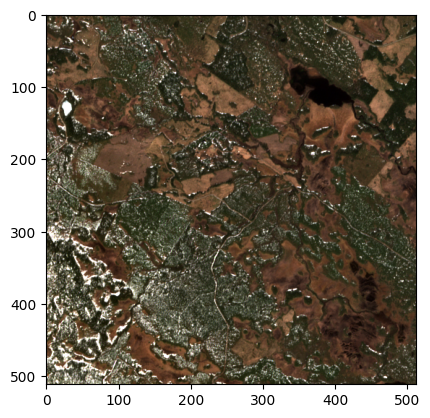

In [8]:
# Visualize a random sample from the ClayDatasetRGB
sample = ds[42] # pick a random sample
bgr = rearrange(sample["pixels"].cpu().numpy(), "c h w -> h w c") # rearrange to h,w,c
rgb = bgr[..., ::-1] # reverse the order of the channels
plt.imshow(rgb/2000)

In [9]:
dm = ClayDataModuleRGB(data_dir=str(data_dir), batch_size=8)
dm.setup(stage="fit")

# Load the train DataLoader
trn_dl = iter(dm.train_dataloader())

Total number of chips: 414


In [10]:
# Load the first batch of chips
batch = next(trn_dl)
batch.keys()

dict_keys(['pixels', 'bbox', 'epsg', 'date', 'latlon', 'timestep', 'source_url'])

In [11]:
batch["pixels"].shape, batch["latlon"].shape, batch["timestep"].shape

(torch.Size([8, 3, 512, 512]), torch.Size([8, 2]), torch.Size([8, 3]))

Each batch has chips of shape `3 x 512 x 512`, normalized `lat` & `lon` coords & normalized timestep information as `year`, `month` & `day`.

In [14]:
# Pass the pixels through the encoder & decoder of CLAY
with torch.no_grad():
    # Move data from to the device of model
    batch["pixels"] = batch["pixels"].to(rgb_model.device) # Pass just the specific band through the model
    batch["timestep"] = batch["timestep"].to(rgb_model.device)
    batch["latlon"] = batch["latlon"].to(rgb_model.device)

    # Pass pixels, latlon, timestep through the encoder to create encoded patches
    unmasked_patches, unmasked_indices, masked_indices, masked_matrix = rgb_model.model.encoder(batch)

    # Pass the unmasked_patches through the decoder to reconstruct the pixel space
    pixels = rgb_model.model.decoder(unmasked_patches, unmasked_indices, masked_indices)

In [15]:
unmasked_patches.shape, unmasked_indices.shape, masked_indices.shape, masked_matrix.shape

(torch.Size([8, 79, 768]),
 torch.Size([8, 77]),
 torch.Size([8, 179]),
 torch.Size([8, 1, 256]))

In [16]:
# Reconstructed chips from 70% masked inputs to the model
pixels.shape

torch.Size([8, 3, 256, 1024])

In [17]:
# Rearrange the pixels into chips of size `3 x 512 x 512`
pixels = rearrange(pixels, "b c (h w) (p1 p2) -> b c (h p1) (w p2)", h=16, p1=32)
pixels.shape

torch.Size([8, 3, 512, 512])

## Plot the pixel reconstructions for RGB bands from the CLAY model

In [18]:
def plot_pixel_reconstruction():
    fig, axes = plt.subplots(16, 3, figsize=(5,20))

    for j in range(8):
        inp = batch["pixels"][j].detach().cpu().numpy()
        out = pixels[j].detach().cpu().numpy()
        j *= 2
        for i in range(3):
            axes[j, i].imshow(inp[i], cmap="viridis")
            axes[(j+1), i].imshow(out[i], cmap="viridis")
            axes[j, i].set_axis_off()
            axes[(j+1), i].set_axis_off()

    plt.tight_layout()

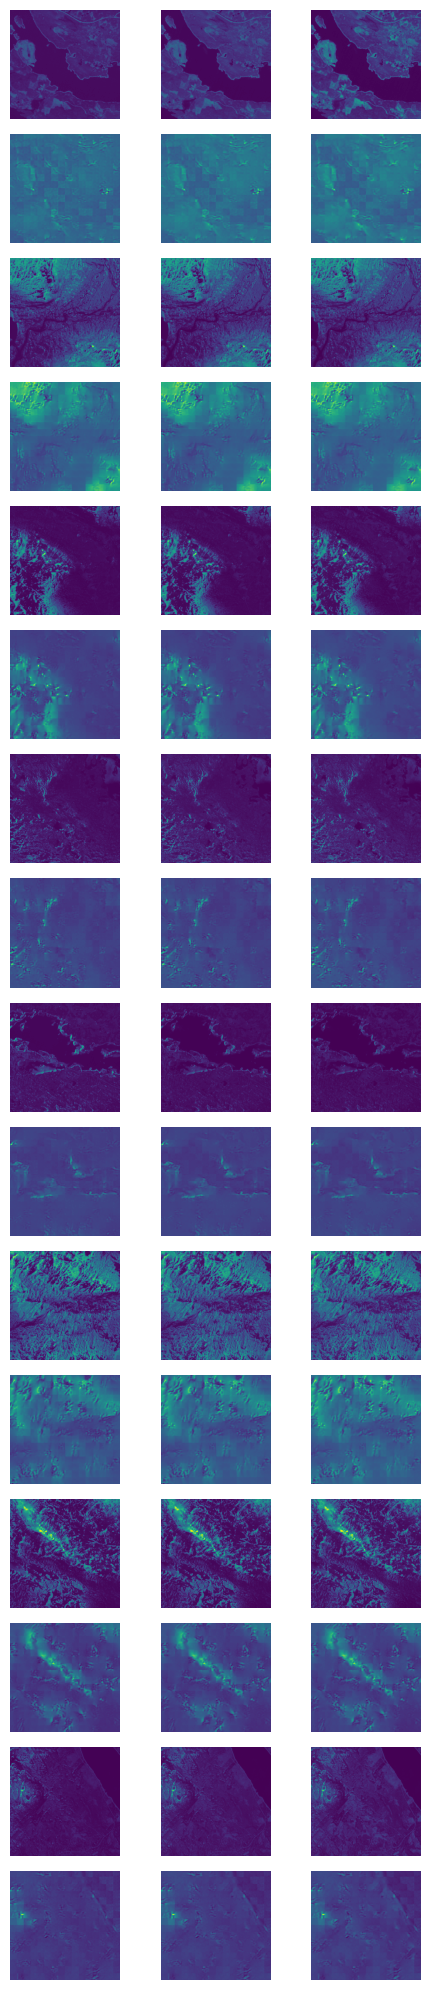

In [19]:
plot_pixel_reconstruction()

# SAR Inputs

## Load the CLAY model

In [20]:
# Load the best checkpoint from CLAY v0
sar_model = CLAYModule.load_from_checkpoint(
    CKPT_PATH, 
    mask_ratio=0.7, # mask out 70% of the input patches
    shuffle=True, # shuffle the input patches
    bands=2, # use VV & VH bands
    band_groups={"sar": (0,1)}, # band order is VV,VH
    strict=False # ignore the extra parameters in the checkpoint
)
sar_model.eval(); # set the model to evaluation mode

/home/mjonir/mambaforge/envs/claymodel/lib/python3.11/site-packages/lightning/pytorch/core/saving.py:177: Found keys that are not in the model state dict but in the checkpoint: ['model.encoder.patch_embedding.rgb.proj.weight', 'model.encoder.patch_embedding.rgb.proj.bias', 'model.encoder.patch_embedding.rgb.norm.weight', 'model.encoder.patch_embedding.rgb.norm.bias', 'model.encoder.patch_embedding.rededge.proj.weight', 'model.encoder.patch_embedding.rededge.proj.bias', 'model.encoder.patch_embedding.rededge.norm.weight', 'model.encoder.patch_embedding.rededge.norm.bias', 'model.encoder.patch_embedding.nir.proj.weight', 'model.encoder.patch_embedding.nir.proj.bias', 'model.encoder.patch_embedding.nir.norm.weight', 'model.encoder.patch_embedding.nir.norm.bias', 'model.encoder.patch_embedding.swir.proj.weight', 'model.encoder.patch_embedding.swir.proj.bias', 'model.encoder.patch_embedding.swir.norm.weight', 'model.encoder.patch_embedding.swir.norm.bias', 'model.encoder.patch_embedding.dem

## Create an SAR variant of ClayDataset & ClayDataModule by subclassing

In [21]:
class ClayDatasetSAR(ClayDataset):
    def read_chip(self, chip_path):
        """Read just the VV & VH bands from a chip."""
        # Chips for clay have bands from Sentinel 2, Sentinel 1 & DEM. There are 13 bands in total.
        # Sentinel-2 bands: B02, B03, B04, B05, B06, B07, B08, B8A, B11, B12
        # Sentinel-1 bands: VV, VH
        # DEM band: DEM
        chip = rio.open(chip_path)

        # read timestep & normalize
        date = chip.tags()["date"]  # YYYY-MM-DD
        year, month, day = self.normalize_timestamp(date)

        # read lat,lon from UTM to WGS84 & normalize
        bounds = chip.bounds  # xmin, ymin, xmax, ymax
        epsg = chip.crs.to_epsg()  # e.g. 32632
        lon, lat = chip.lnglat()  # longitude, latitude
        lon, lat = self.normalize_latlon(lon, lat)

        return {
            "pixels": chip.read([11, 12]), # read VV, VH bands as 0,1 indices
            # Raw values
            "bbox": bounds,
            "epsg": epsg,
            "date": date,
            # Normalized values
            "latlon": (lat, lon),
            "timestep": (year, month, day),
        }
    
class ClayDataModuleSAR(ClayDataModule):
    MEAN = [
        0.026,
        0.118,
    ]
    STD = [
        0.118,
        0.873,
    ]
    
    def setup(self, stage: Literal["fit", "predict"] | None = None) -> None:
        # Get list of GeoTIFF filepaths from s3 bucket or data/ folder
        if self.data_dir.startswith("s3://"):
            dp = torchdata.datapipes.iter.IterableWrapper(iterable=[self.data_dir])
            chips_path = list(dp.list_files_by_s3(masks="*.tif"))
        else:  # if self.data_dir is a local data path
            chips_path = list(Path(self.data_dir).glob("**/*.tif"))
        print(f"Total number of chips: {len(chips_path)}")

        if stage == "fit":
            random.shuffle(chips_path)
            split = int(len(chips_path) * self.split_ratio)

            self.trn_ds = ClayDatasetSAR(chips_path=chips_path[:split], transform=self.tfm)
            self.val_ds = ClayDatasetSAR(chips_path=chips_path[split:], transform=self.tfm)

        elif stage == "predict":
            self.prd_ds = ClayDatasetSAR(chips_path=chips_path, transform=self.tfm)

In [22]:
# Load the SAR Clay Dataset
ds = ClayDatasetSAR(chips_path=list(data_dir.glob("**/*.tif")))

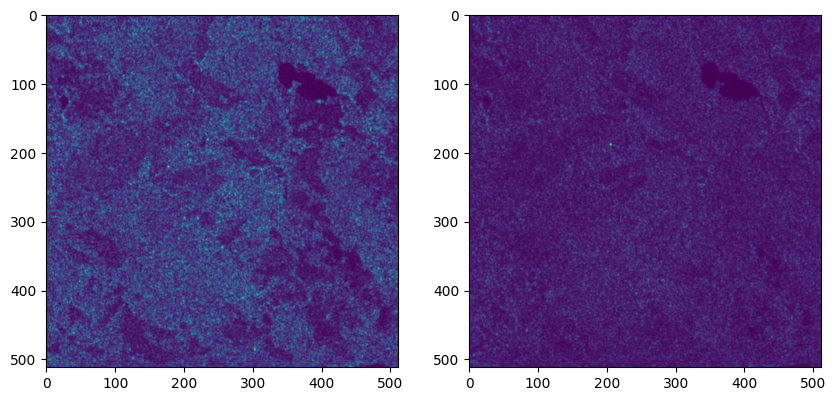

In [23]:
# Visualize a random sample from the ClayDatasetSAR
sample = ds[42] # pick a random sample
sar = rearrange(sample["pixels"].cpu().numpy(), "c h w -> h w c") # rearrange to h,w,c
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(sar[..., 0])
axes[1].imshow(sar[..., 1])

In [24]:
dm = ClayDataModuleSAR(data_dir=str(data_dir), batch_size=8)
dm.setup(stage="fit")

# Load the train DataLoader
trn_dl = iter(dm.train_dataloader())

Total number of chips: 414


In [25]:
# Load the first batch of chips
batch = next(trn_dl)
batch.keys()

dict_keys(['pixels', 'bbox', 'epsg', 'date', 'latlon', 'timestep', 'source_url'])

In [26]:
batch["pixels"].shape, batch["latlon"].shape, batch["timestep"].shape

(torch.Size([8, 2, 512, 512]), torch.Size([8, 2]), torch.Size([8, 3]))

Each batch has chips of shape `2 x 512 x 512`, normalized `lat` & `lon` coords & normalized timestep information as `year`, `month` & `day`.

In [27]:
# Pass the pixels through the encoder & decoder of CLAY
with torch.no_grad():
    # Move data from to the device of model
    batch["pixels"] = batch["pixels"].to(sar_model.device) # Pass just the specific band through the model
    batch["timestep"] = batch["timestep"].to(sar_model.device)
    batch["latlon"] = batch["latlon"].to(sar_model.device)

    # Pass pixels, latlon, timestep through the encoder to create encoded patches
    unmasked_patches, unmasked_indices, masked_indices, masked_matrix = sar_model.model.encoder(batch)

    # Pass the unmasked_patches through the decoder to reconstruct the pixel space
    pixels = sar_model.model.decoder(unmasked_patches, unmasked_indices, masked_indices)

In [28]:
unmasked_patches.shape, unmasked_indices.shape, masked_indices.shape, masked_matrix.shape

(torch.Size([8, 79, 768]),
 torch.Size([8, 77]),
 torch.Size([8, 179]),
 torch.Size([8, 1, 256]))

In [29]:
# Reconstructed chips from 70% masked inputs to the model
pixels.shape

torch.Size([8, 2, 256, 1024])

In [30]:
# Rearrange the pixels into chips of size `2 x 512 x 512`
pixels = rearrange(pixels, "b c (h w) (p1 p2) -> b c (h p1) (w p2)", h=16, p1=32)
pixels.shape

torch.Size([8, 2, 512, 512])

## Plot the pixel reconstructions of VV/VH bands from the CLAY model

In [38]:
def plot_pixel_reconstruction():
    fig, axes = plt.subplots(16, 2, figsize=(5,30))

    for j in range(8):
        inp = batch["pixels"][j].detach().cpu().numpy()
        out = pixels[j].detach().cpu().numpy()
        j *= 2
        for i in range(2):
            axes[j, i].imshow(inp[i], cmap="viridis")
            axes[(j+1), i].imshow(out[i], cmap="viridis")
            axes[j, i].set_axis_off()
            axes[(j+1), i].set_axis_off()

    plt.tight_layout()

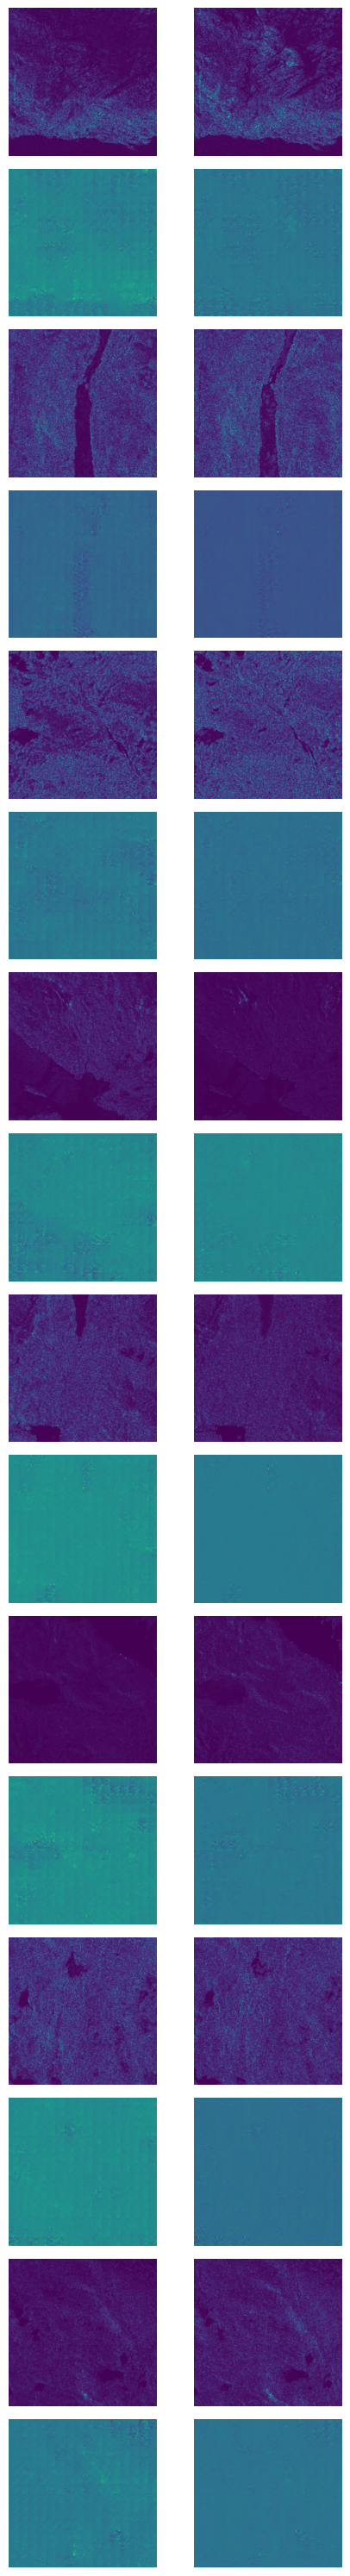

In [39]:
plot_pixel_reconstruction()